# TP3 : Support Vector Machines

In [5]:
#imports
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn import metrics
from time import time
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [2]:
#load dataset
mnist = fetch_openml('mnist_784')

## [1] Echantillonage du jeu de données et séparation en entraînement/test

In [3]:
#choose sample size
dataset_length = len(mnist.data)
sample_size = 7000
sample_size = min(dataset_length,sample_size)

#extract sample from dataset
sample_indexes = np.random.randint(dataset_length, size= sample_size)
data, target = np.array([mnist.data[i] for i in sample_indexes]), np.array([mnist.target[i] for i in sample_indexes])

#extract train/test according to the proportion given in the subject
train_size = 70/100 #70% de test
d_train, d_test, l_train, l_test = train_test_split(data,target,train_size = train_size, random_state = 42)

## [2] Premières machines

In [8]:
clsvm = SVC(kernel='linear')
clsvm.fit(d_train,l_train)
prediction = clsvm.predict(d_test[0:1])[0]
actual= l_test[0]
print("First prediction :",prediction,"Actual :",actual)

First prediction : 1 Actual : 1


## [3] Analyse

#### Paramètre noyau
Note : Le paramètre 'precomputed' permet d'indiquer que l'input de la machine a déjà été transformée et redimensionnée, via une opération personalisée au lieu des stndards proposés. Nous n'avions pas de fonctions de transformation particulière à tester, cette option est donc ignorée dans le test.
On peut également obtenir le même comportement en passant une fonction de noyau comme argument kernel, qui sera alors appliquée à l'entrée de la machine.

In [12]:
kernel_set = ['linear','poly', 'rbf','sigmoid']
plot = ([],[],[],[],[])
for kernel in kernel_set:
    print("Kernel :",kernel)
    start = time()#TIMER START
    
    clsvm = SVC(kernel = kernel)
    clsvm.fit(d_train,l_train)
    prediction = clsvm.predict(d_test)
    
    duration = time() - start #TIMER END
    
    recall = metrics.recall_score(l_test, prediction, average = 'micro')
    score = metrics.precision_score(l_test, prediction, average='micro')
    error = metrics.zero_one_loss(l_test, prediction)
    
    plot[0].append(kernel)
    plot[1].append(100*score)
    plot[2].append(100*recall)
    plot[3].append(error)
    plot[4].append(duration)

Kernel : linear
Kernel : poly
Kernel : rbf
Kernel : sigmoid


Text(0,0.5,'Execution(s)')

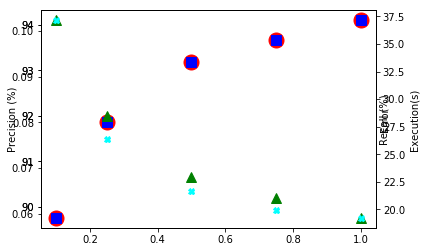

In [24]:
fig=plt.figure()
ax1=fig.add_subplot(111, label="precision")
ax2=ax1.twinx()
ax3=ax2.twinx()
ax4=ax3.twinx()

ax1.plot(plot[0],plot[1],linestyle='None',marker='o',ms=15.0,color='r')
ax1.set_ylabel("Precision (%)")
ax2.plot(plot[0],plot[2],linestyle='None',marker='s',ms=10,color='b')
ax2.set_ylabel("Recall (%)")
ax3.plot(plot[0],plot[3],linestyle='None',marker='^',ms=10,color='g')
ax3.set_ylabel("Error")
ax4.plot(plot[0],plot[4],linestyle='None',marker='X',color='cyan')
ax4.set_ylabel("Execution(s)")

#### Interprétation
La fonction rbf obtient les meilleurs résultats, surpassant les trois autres en terme de précision,recall,erreur.
Cependant, elle est également la plus lente. La fonction linear est plus rapide au prix d'une dégradation de rappel et précision. Les deux autres fonctions semblent moins pertinentes pour ce cas : la fonction poly obtient de bons scores mais qui demeure inférieurs à ceux de la fonction rbf, pour un temps d'exécution proche. La fonction sigmoïde obtient les pires scores pour un temps d'exécution là aussi comparable à rbf, à éviter donc.

#### Tolérance aux erreurs

In [22]:
kernel = 'rbf'
plot = ([],[],[],[],[])
c_set = [0.1,0.25,0.50,0.75,1.0]

for c in c_set:
    print("C :",c)
    start = time()#TIMER START
    
    clsvm = SVC(kernel = kernel, C = c)
    clsvm.fit(d_train,l_train)
    prediction = clsvm.predict(d_test)
    
    duration = time() - start #TIMER END
    
    recall = metrics.recall_score(l_test, prediction, average = 'micro')
    score = metrics.precision_score(l_test, prediction, average='micro')
    error = metrics.zero_one_loss(l_test, prediction)
    
    plot[0].append(c)
    plot[1].append(100*score)
    plot[2].append(100*recall)
    plot[3].append(error)
    plot[4].append(duration)

C : 0.1
C : 0.25
C : 0.5
C : 0.75
C : 1.0


Text(0,0.5,'Execution(s)')

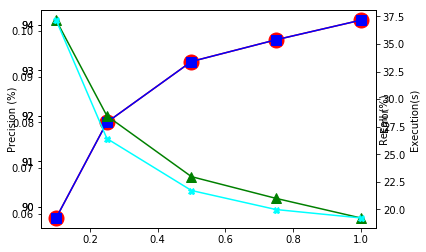

In [23]:
fig=plt.figure()
ax1=fig.add_subplot(111, label="precision")
ax2=ax1.twinx()
ax3=ax2.twinx()
ax4=ax3.twinx()

ax1.plot(plot[0],plot[1],marker='o',ms=15.0,color='r')
ax1.set_ylabel("Precision (%)")
ax2.plot(plot[0],plot[2],marker='s',ms=10,color='b')
ax2.set_ylabel("Recall (%)")
ax3.plot(plot[0],plot[3],marker='^',ms=10,color='g')
ax3.set_ylabel("Error")
ax4.plot(plot[0],plot[4],marker='X',color='cyan')
ax4.set_ylabel("Execution(s)")

#### Interprétation
Il apparaît que les meilleurs scores sont obtenus avec une tolérance maximale. Celà s'accompagne de plus d'un temps d'éxécution réduit.

## Paramètres retenus
Pour le classifieur SVC, nos résultats indiquent donc qu'il est optimal d'utiliser la fonction noyau RBF et une tolérance aux erreurs de 1.0.
On retiendra également l'alternative d'utiliser la fonction linear pour des temps d'entraînement plus rapides.

## Conclusion sur SVC

## FIN TP3